# BirdCLEF 2023 - Model Fitting 1

The goal here is to apply the guidelines and approach presented in the [First Steps, Road to the Top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) series of notebooks. Following that series, we'll look to use FastAI/PyTorch to create an effective validation set and iterate rapidly!

To overall plan is to start with transfer learning to train CNNs on spectrograms.

This notebook focuses transfer learning to train CNNs on spectrograms.

## Competition
https://www.kaggle.com/competitions/birdclef-2023

## Inputs
Original Ogg files with noise removed, downsampled, and resized to 30s.

<!-- | Notebook | Version |
| :-------- | :-----: |
| https://www.kaggle.com/code/stephenhudson/rsna-smbcd-2023-eda-part-1 | 3 |
| https://www.kaggle.com/code/stephenhudson/rsna-smbcd-2023-eda-part-2 | 2 |
| https://www.kaggle.com/code/stephenhudson/rsna-smbcd-2023-data-prep | 3 |
| https://www.kaggle.com/code/stephenhudson/rsna-smbcd-2023-data-prep-partition | 2 |
 -->

# Setup
## Kaggle

In [1]:
from fastkaggle import setup_comp, iskaggle

comp  = 'birdclef-2023'
comp_path = setup_comp(comp, install='fastai timm fastaudio')
comp_path.ls()

(#11) [Path('birdclef-2023/train_audio_prep-2'),Path('birdclef-2023/eBird_Taxonomy_v2021.csv'),Path('birdclef-2023/test_soundscapes'),Path('birdclef-2023/train_metadata.csv'),Path('birdclef-2023/train_audio_prep-2b'),Path('birdclef-2023/train_audio_prep-20-60s-32k'),Path('birdclef-2023/train_audio'),Path('birdclef-2023/sample_submission.csv'),Path('birdclef-2023/train_audio_prep'),Path('birdclef-2023/train_audio_prep-30s-32k')...]

## Imports

In [2]:
import pandas as pd

from fastai.vision.all import *
import torch
import timm
import sklearn.metrics
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from fastaudio.core.all import *
from fastaudio.augment.all import *

from pathlib import Path
import time
import pickle
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

print(torch.__version__)

/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


2.0.0+cu117


In [3]:
assert torch.cuda.is_available(), 'Cuda is not available!'

# Config

In [4]:
wandb_on = True
wandb_project = 'birdclef-2023'
wandb_group = 'data_prep'

lr_find_on = True
max_images = None

## Debugging

In [5]:
debug_on = False

if debug_on:
    lr_find_on = False
    wandb_on = False
    max_images = 1024  # for debugging. Set to None to use all

## Hyperparameters

In [6]:
hypp = dict(
    wandb_group=wandb_group,
    batch_size=8,
    effective_batch_size=64,
    n_epochs=8,
    # nn_arch='mixnet_s',
    nn_arch='convnext_tiny_in22k',
    freeze_epochs=1,
    base_lr = 2e-2,
    approach='Vanilla',
    to_fp16 = True,
    n_in=1,
    
    # Details about data preprocesing
    # TODO: have the preprocessing notebook save the details or specify them in yaml so they can
    #       be automatically picked up here
    data_prep_details=dict(
        prep_dir='train_audio_prep-20-60s-32k',
        sample_rate=32000,
        remove_silence_type='All',
        remove_silence_threshold=30,
        min_size_ms=20000,
        max_size_ms=60000,
        train_size_ms=20000,
        min_rating=2.5
    ),

    # Spectrogram augmentation
    audio_augmentation=dict(
        add_freq_mask=True,
        freq_mask_num=3,
        freq_mask_size=5,
        add_time_mask=True,
        time_mask_num=2,
        time_mask_size=100,
        add_delta=False
    ),
    
    # For BasicMelSpectrogram
    spectrogram_type='Mel',
    audio_config=dict(
        sample_rate=32000,
        n_fft=512,
        win_length=None,
        hop_length=None,
        f_min=10.0,
        f_max=16000,
        n_mels=128,
        power=2.0,
        normalized=False,
        center=True,
        pad_mode='reflect',
        mel=True,
        to_db=True
    )
    
    # For BasicMFCC
    # spectrogram_type='MFCC',
    # audio_config=dict(
    #     sample_rate=32000,
    #     n_mfcc=40,
    #     dct_type=2,
    #     norm='ortho',
    #     log_mels=False,
    #     melkwargs=dict(
    #         n_fft=512,
    #         hop_length=None,
    #         n_mels=64
    #     )
    # )
)

trn_path = comp_path/hypp['data_prep_details']['prep_dir']

In [7]:
hypp

{'wandb_group': 'data_prep',
 'batch_size': 8,
 'effective_batch_size': 64,
 'n_epochs': 8,
 'nn_arch': 'convnext_tiny_in22k',
 'freeze_epochs': 1,
 'base_lr': 0.02,
 'approach': 'Vanilla',
 'to_fp16': True,
 'n_in': 1,
 'data_prep_details': {'prep_dir': 'train_audio_prep-20-60s-32k',
  'sample_rate': 32000,
  'remove_silence_type': 'All',
  'remove_silence_threshold': 30,
  'min_size_ms': 20000,
  'max_size_ms': 60000,
  'train_size_ms': 20000,
  'min_rating': 2.5},
 'audio_augmentation': {'add_freq_mask': True,
  'freq_mask_num': 3,
  'freq_mask_size': 5,
  'add_time_mask': True,
  'time_mask_num': 2,
  'time_mask_size': 100,
  'add_delta': False},
 'spectrogram_type': 'Mel',
 'audio_config': {'sample_rate': 32000,
  'n_fft': 512,
  'win_length': None,
  'hop_length': None,
  'f_min': 10.0,
  'f_max': 16000,
  'n_mels': 128,
  'power': 2.0,
  'normalized': False,
  'center': True,
  'pad_mode': 'reflect',
  'mel': True,
  'to_db': True}}

## Weights & Biases

In [8]:
wandb_run = None
if wandb_on:
    import wandb
    from fastai.callback.wandb import *
    wandb.init(project=wandb_project, config=hypp)
    wandb_callback = WandbCallback(log_preds=False)

wandb: Currently logged in as: sdhca. Use `wandb login --relogin` to force relogin


# Model Selection

Useful resources:
 * https://timm.fast.ai/
 * https://huggingface.co/docs/timm/results
 * https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
 * https://towardsdatascience.com/does-imagenet-pretraining-work-for-chest-radiography-images-covid-19-2e2d9f5f0875
 * https://towardsdatascience.com/getting-started-with-pytorch-image-models-timm-a-practitioners-guide-4e77b4bf9055
 
 Let's start with `mixnet_s` for fast iteration because it has only 4 M parameters.

In [9]:
timm.list_models('mixnet*', pretrained=True)

['mixnet_l', 'mixnet_m', 'mixnet_s', 'mixnet_xl']

In [10]:
timm.list_models('*efficient*', pretrained=True)

['efficientformer_l1',
 'efficientformer_l3',
 'efficientformer_l7',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b4',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_lite0',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'gc_efficientnetv2_rw_t',
 'tf_efficientnet_b0',
 'tf_efficientnet_b0_ap',
 'tf_efficientnet_b0_ns',
 'tf_efficientnet_b1',
 'tf_efficientnet_b1_ap',
 'tf_efficientnet_b1_ns',
 'tf_efficientnet_b2',
 'tf_efficientnet_b2_ap',
 'tf_efficientnet_b2_ns',
 'tf_efficientnet_b3',
 'tf_efficientnet_b3_ap',
 'tf_efficientnet_b3_ns',
 'tf_efficientnet_b4',
 'tf_efficientnet_b4_ap',
 'tf_efficientnet_b4_ns',
 'tf_efficientnet_b5',
 'tf_efficientnet_b5_ap',
 'tf_efficientnet_b5_ns',
 'tf_efficientnet_b6',
 'tf_efficientnet_b6_ap',
 'tf_efficientn

In [11]:
# model = timm.create_model(hypp['nn_arch'], pretrained=True, num_classes=2, in_chans=3)
model, model_cfg = create_timm_model(hypp['nn_arch'], n_out=264, pretrained=True, n_in=1)
model_cfg

{'url': 'https://dl.fbaipublicfiles.com/convnext/convnext_tiny_22k_224.pth',
 'num_classes': 21841,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'stem.0',
 'classifier': 'head.fc',
 'architecture': 'convnext_tiny_in22k'}

In [12]:
img_size = model_cfg['input_size'][1]
img_size

224

In [13]:
del(model)

# Splits & DataLoaders

In [14]:
comp_path.ls()

(#11) [Path('birdclef-2023/train_audio_prep-2'),Path('birdclef-2023/eBird_Taxonomy_v2021.csv'),Path('birdclef-2023/test_soundscapes'),Path('birdclef-2023/train_metadata.csv'),Path('birdclef-2023/train_audio_prep-2b'),Path('birdclef-2023/train_audio_prep-20-60s-32k'),Path('birdclef-2023/train_audio'),Path('birdclef-2023/sample_submission.csv'),Path('birdclef-2023/train_audio_prep'),Path('birdclef-2023/train_audio_prep-30s-32k')...]

In [15]:
trn_df = pd.read_csv(comp_path/'train_metadata.csv')
if max_images:
    trn_df = trn_df.head(n=max_images)
trn_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


## Filter by audio rating

In [16]:
len(trn_df)

16941

In [17]:
if hypp['data_prep_details']['min_rating']:
    trn_df = trn_df[trn_df.rating >= hypp['data_prep_details']['min_rating']]
    print(len(trn_df))

15580


## Double-Up Classes with One Instance

In [18]:
solitary_labels = trn_df.pivot_table('filename', 'primary_label', aggfunc='count').query('filename==1').index.to_list()
solitary_labels

['afpkin1',
 'brtcha1',
 'crefra2',
 'golher1',
 'lotcor1',
 'whctur2',
 'whhsaw1',
 'yebsto1']

In [19]:
solitary_df = trn_df[trn_df.primary_label.isin(solitary_labels)]
trn_df = pd.concat([trn_df, solitary_df])

In [20]:
trn_df = trn_df.reset_index()

## Train-Test Split
With 5 splits, we can just take the last pair of train and test indices to have an 80:20 train:test split.

In [21]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
splits = sss.split(trn_df, trn_df.primary_label)

for trn_idx, tst_idx in splits:
    print(len(trn_idx), len(tst_idx), len(trn_idx) + len(tst_idx))

14029 1559 15588


## DataBlock

In [22]:
def _get_label(df, label_col):
    return df[label_col]

get_label = partial(_get_label, label_col='primary_label')

In [23]:
from fastcore.transform import Pipeline

# Mel Spectrogram or MFCC
resize = ResizeSignal(duration=20e3)
cfg = AudioConfig.BasicMelSpectrogram(**hypp['audio_config'])
a2s = AudioToSpec.from_cfg(cfg)
# cfg = AudioConfig.BasicMFCC(**hypp['audio_config'])
# a2s = AudioToMFCC.from_cfg(cfg)
item_tfms = [resize, a2s]

# Add spectrogram augmentation
hypp_aug=hypp['audio_augmentation']

if hypp_aug['add_freq_mask']:
    mask_freq = MaskFreq(num_masks=hypp_aug['freq_mask_num'], size=hypp_aug['freq_mask_size'])
    item_tfms.append(mask_freq)
    
if hypp_aug['add_time_mask']:
    mask_time = MaskTime(num_masks=hypp_aug['time_mask_num'], size=hypp_aug['time_mask_size'])
    item_tfms.append(mask_time)

# delta = Delta()
# batch_tfms = Pipeline([mask_freq, mask_time])
# item_tfms = [a2s, delta, mask_freq, mask_time]

batch_tfms = []

/home/sdhca/mambaforge/envs/fastai/lib/python3.9/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [24]:
db = DataBlock(blocks=(AudioBlock, CategoryBlock),
               get_x=ColReader('filename', pref=trn_path),
               get_y=get_label,
               splitter=IndexSplitter(tst_idx),
               item_tfms = item_tfms,
               batch_tfms = batch_tfms)

In [25]:
db.summary(trn_df)

Setting-up type transforms pipelines
0          0       abethr1                                []   
1          1       abethr1                                []   
2          2       abethr1                                []   
3          3       abethr1                                []   
4          4       abethr1                                []   
...      ...           ...                               ...   
15583   7684       golher1                                []   
15584  10173       lotcor1  ['blakit1', 'categr', 'grbcam1']   
15585  15167       whctur2                                []   
15586  15185       whhsaw1                                []   
15587  16508       yebsto1                                []   

                   type  latitude  longitude         scientific_name  \
0              ['song']    4.3906    38.2788      Turdus tephronotus   
1              ['call']   -2.9524    38.2921      Turdus tephronotus   
2              ['song']   -2.9524    38.29

## DataLoaders

In [26]:
test_dls = db.dataloaders(trn_df, bs=1)

In [27]:
test_data = next(iter(test_dls.train))

In [28]:
test_data[0].shape

torch.Size([1, 1, 128, 1251])

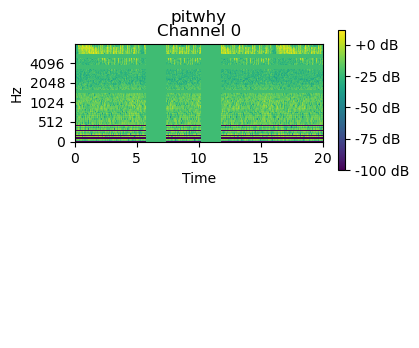

In [29]:
test_dls.show_batch()

In [30]:
dls = db.dataloaders(trn_df, bs=hypp['batch_size'], num_workers=8, pin_memory=True, drop_last=True)

In [31]:
L(dls.vocab)

(#264) ['abethr1','abhori1','abythr1','afbfly1','afdfly1','afecuc1','affeag1','afgfly1','afghor1','afmdov1'...]

In [32]:
if not debug_on:
    assert len(dls.vocab) == 264, 'Some classes are not in the training set!'

### Show Batch

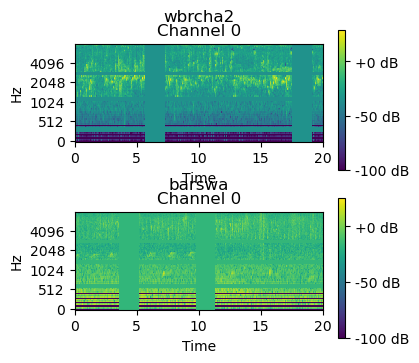

In [33]:
dls.show_batch(max_n=10)

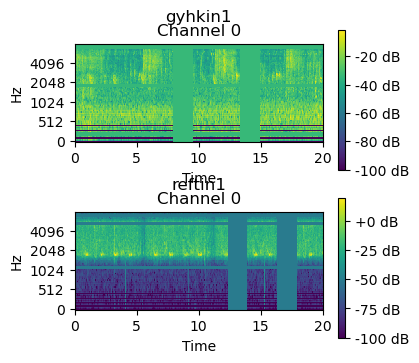

In [34]:
dls.show_batch(max_n=10)

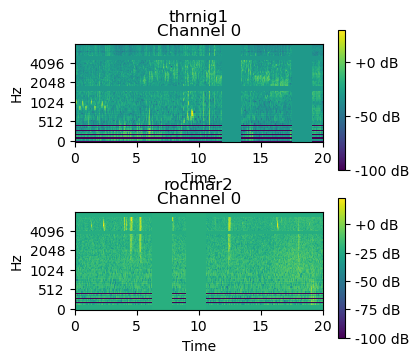

In [35]:
dls.show_batch(max_n=10)

# Metrics
## cmAP, cmAP_probs, padded_cmAP, padded_cmAP_probs
Metrics calculated here aren't comparable to those on the Kaggle leaderboard because the proportion of real samples to padding samples differ. 

On kaggle, we have 5 padding rows for about 24,000 real rows (1:4800). Here (before any major resampling), are setting the padding factor to 1 because that already gives a higher ratio of padded rows (~1:1600)

In [36]:
from sklearn.metrics import average_precision_score

# Debugging variables and metric function
preds_test = None
labels_test = None
probs_test = None
labels_oh_test = None
padding_test = None

def cmAP_debug(preds, labels, num_classes=264):
    global preds_test
    preds_test = preds
    probs = F.one_hot(torch.argmax(preds, dim=1)).cpu().numpy()
    global probs_test
    probs_test = probs
    global labels_test
    labels_test = labels
    labels_oh = F.one_hot(labels, num_classes=num_classes).cpu().numpy()
    global labels_oh_test
    labels_oh_test = labels_oh
    return average_precision_score(labels_oh, probs, average='macro')

def padded_cmAP_debug(preds, labels, num_classes=264, padding_factor=1):
    global preds_test
    preds_test = preds
    padding = torch.ones((padding_factor, num_classes))
    global padding_test
    padding_test = padding
    probs = torch.cat((F.one_hot(torch.argmax(preds, dim=1), num_classes=num_classes).cpu(), padding)).numpy()
    global probs_test
    probs_test = probs
    labels_oh = torch.cat((F.one_hot(labels, num_classes=num_classes).cpu(), padding)).numpy()
    global labels_oh_test
    labels_oh_test = labels_oh
    return average_precision_score(labels_oh, probs, average='macro')
    # return 0.0


def cmAP(preds, labels, num_classes=264):
    probs = F.one_hot(torch.argmax(preds, dim=1), num_classes=num_classes).cpu().numpy()
    labels_oh = F.one_hot(labels, num_classes=num_classes).cpu().numpy()
    return average_precision_score(labels_oh, probs, average='macro')

def cmAP_probs(preds, labels, num_classes=264):
    probs = F.softmax(preds, dim=1).cpu().numpy()
    labels_oh = F.one_hot(labels, num_classes=num_classes).cpu().numpy()
    return average_precision_score(labels_oh, probs, average='macro')

def padded_cmAP(preds, labels, num_classes=264, padding_factor=1):
    padding = torch.ones((padding_factor, num_classes))
    probs = torch.cat((F.one_hot(torch.argmax(preds, dim=1), num_classes=num_classes).cpu(), padding)).numpy()
    labels_oh = torch.cat((F.one_hot(labels, num_classes=num_classes).cpu(), padding)).numpy()
    return average_precision_score(labels_oh, probs, average='macro')

def padded_cmAP_probs(preds, labels, num_classes=264, padding_factor=1):
    padding = torch.ones((padding_factor, num_classes))
    probs = torch.cat((F.softmax(preds, dim=1).cpu(), padding)).numpy()
    labels_oh = torch.cat((F.one_hot(labels, num_classes=num_classes).cpu(), padding)).numpy()
    return average_precision_score(labels_oh, probs, average='macro')

## plot_metrics

In [37]:
# https://forums.fast.ai/t/plotting-metrics-after-learning/69937/3
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

# Train Model

In [38]:
hypp

{'wandb_group': 'data_prep',
 'batch_size': 8,
 'effective_batch_size': 64,
 'n_epochs': 8,
 'nn_arch': 'convnext_tiny_in22k',
 'freeze_epochs': 1,
 'base_lr': 0.02,
 'approach': 'Vanilla',
 'to_fp16': True,
 'n_in': 1,
 'data_prep_details': {'prep_dir': 'train_audio_prep-20-60s-32k',
  'sample_rate': 32000,
  'remove_silence_type': 'All',
  'remove_silence_threshold': 30,
  'min_size_ms': 20000,
  'max_size_ms': 60000,
  'train_size_ms': 20000,
  'min_rating': 2.5},
 'audio_augmentation': {'add_freq_mask': True,
  'freq_mask_num': 3,
  'freq_mask_size': 5,
  'add_time_mask': True,
  'time_mask_num': 2,
  'time_mask_size': 100,
  'add_delta': False},
 'spectrogram_type': 'Mel',
 'audio_config': {'sample_rate': 32000,
  'n_fft': 512,
  'win_length': None,
  'hop_length': None,
  'f_min': 10.0,
  'f_max': 16000,
  'n_mels': 128,
  'power': 2.0,
  'normalized': False,
  'center': True,
  'pad_mode': 'reflect',
  'mel': True,
  'to_db': True}}

## Create Learner

In [39]:
# learn = vision_learner(dls, hypp['nn_arch'], n_in=1, n_out=264, path='.', loss_func=BCEWithLogitsLossFlat(reduction='sum'))
# learn = vision_learner(dls, hypp['nn_arch'], n_in=hypp['n_in'], n_out=264, path='.', metrics=[error_rate, APScoreMulti(sigmoid=False)])
# learn = vision_learner(dls, hypp['nn_arch'], n_in=hypp['n_in'], n_out=264, path='.', metrics=[error_rate, cmAP, cmAP_probs, padded_cmAP_debug])
# learn = vision_learner(dls, hypp['nn_arch'], n_in=hypp['n_in'], n_out=264, path='.', metrics=[error_rate, cmAP, cmAP_probs, padded_cmAP, padded_cmAP_probs])
# learn = vision_learner(dls, hypp['nn_arch'], n_in=hypp['n_in'], n_out=264, path='.', metrics=[error_rate, padded_cmAP, padded_cmAP_probs])

# We want to pad cmAP metrics once per validation epoch, not once per validation batch
padded_cmAP_score = AccumMetric(padded_cmAP, flatten=False, name='padded_cmAP')
padded_cmAP_probs_score = AccumMetric(padded_cmAP_probs, flatten=False, name='padded_cmAP_probs')
learn = vision_learner(dls, hypp['nn_arch'], n_in=hypp['n_in'], n_out=264, path='.', metrics=[error_rate, padded_cmAP_score, padded_cmAP_probs_score])

if hypp['batch_size'] != hypp['effective_batch_size']:
    learn.add_cb(GradientAccumulation(hypp['effective_batch_size']))

if hypp['to_fp16']:
    print('Switching to mixed precision')
    learn = learn.to_fp16()

Switching to mixed precision


In [40]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [41]:
learn.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

In [42]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, GradientAccumulation, MixedPrecision, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [CastToTensor, MixedPrecision]
         - after_pred     : [MixedPrecision]
         - after_loss     : [GradientAccumulation, MixedPrecision]
         - before_backward: [MixedPrecision]
         - before_step    : [GradientAccumulation, MixedPrecision]
         - after_step     : [MixedPrecision]
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs sam

## LR Find - Head

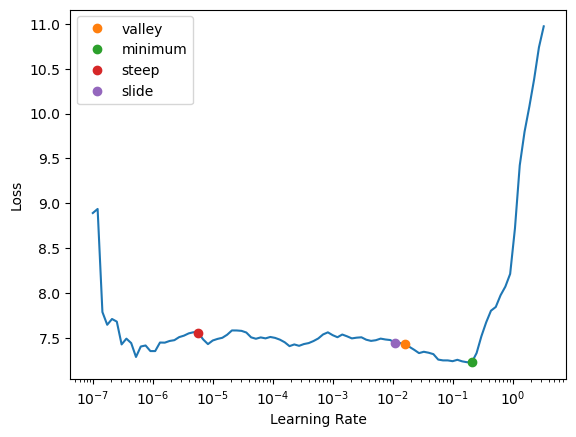

In [43]:
# %%capture --no-stdout --no-display
if lr_find_on:
    learn.lr_find(suggest_funcs=(valley, minimum, steep, slide))

## Fine Tune

In [44]:
learn.add_cb(SaveModelCallback(monitor='error_rate', fname=f"birdclef-2023-{hypp['nn_arch']}"))

if wandb_on:
    print('Adding wandb.ai callback')
    learn.add_cb(wandb_callback)

Adding wandb.ai callback


In [45]:
# %%capture --no-stderr
learn.fine_tune(hypp['n_epochs'],
                freeze_epochs=hypp['freeze_epochs'], 
                base_lr=hypp['base_lr'])

epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,4.004957,3.526515,0.720975,0.335599,0.459719,03:09


Better model found at epoch 0 with error_rate value: 0.7209749817848206.


epoch,train_loss,valid_loss,error_rate,padded_cmAP,padded_cmAP_probs,time
0,2.774758,2.620820,0.572162,0.385449,0.573967,03:23
1,2.616565,2.240307,0.470815,0.436654,0.638749,03:23
2,2.161791,1.897385,0.409878,0.470225,0.694876,03:23
3,1.823911,1.660217,0.357922,0.506706,0.730457,03:23
4,1.458618,1.511954,0.313021,0.550220,0.754350,03:23
5,1.242066,1.357229,0.290571,0.568418,0.781074,03:25
6,1.027258,1.291761,0.273252,0.582999,0.790740,03:24
7,0.920873,1.307541,0.276459,0.582620,0.789330,03:22


Better model found at epoch 0 with error_rate value: 0.5721616148948669.
Better model found at epoch 1 with error_rate value: 0.47081461548805237.
Better model found at epoch 2 with error_rate value: 0.409878134727478.
Better model found at epoch 3 with error_rate value: 0.3579217493534088.
Better model found at epoch 4 with error_rate value: 0.31302115321159363.
Better model found at epoch 5 with error_rate value: 0.2905708849430084.
Better model found at epoch 6 with error_rate value: 0.27325206995010376.


## Debug cmAP

In [46]:
# print(preds_test.shape)
# print(padding_test.shape)
# print(probs_test.shape)
# print(labels_test.shape)
# print(labels_oh_test.shape)

## Hack transforms

In [47]:
learn.dls.valid.after_item.fs

(#7) [Resample:
encodes: (AudioTensor,object) -> encodes
decodes: ,DownmixMono:
encodes: (AudioTensor,object) -> encodes
decodes: ,ResizeSignal:
encodes: (AudioTensor,object) -> encodes
decodes: ,AudioToSpec:
encodes: (AudioTensor,object) -> encodes
decodes: ,MaskFreq:
encodes: (AudioSpectrogram,object) -> encodes
(AudioTensor,object) -> encodes
decodes: ,MaskTime:
encodes: (AudioSpectrogram,object) -> encodes
(AudioTensor,object) -> encodes
decodes: ,ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: ]

In [48]:
learn.dls.valid.after_item.fs.pop(4)
learn.dls.valid.after_item.fs.pop(4)
learn.dls.valid.after_item.fs

(#5) [Resample:
encodes: (AudioTensor,object) -> encodes
decodes: ,DownmixMono:
encodes: (AudioTensor,object) -> encodes
decodes: ,ResizeSignal:
encodes: (AudioTensor,object) -> encodes
decodes: ,AudioToSpec:
encodes: (AudioTensor,object) -> encodes
decodes: ,ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: ]

## Check Results

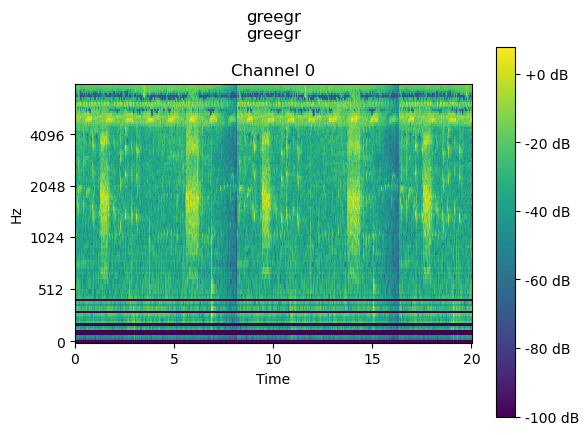

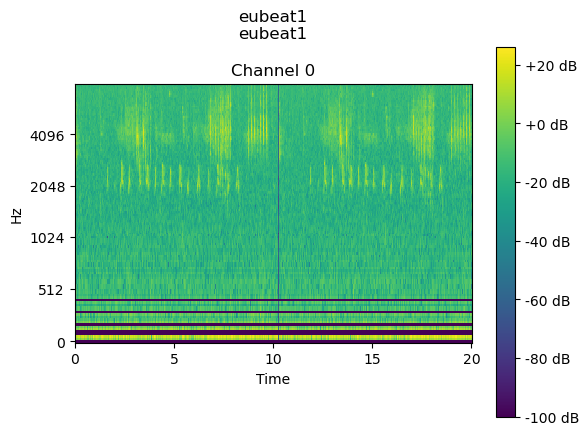

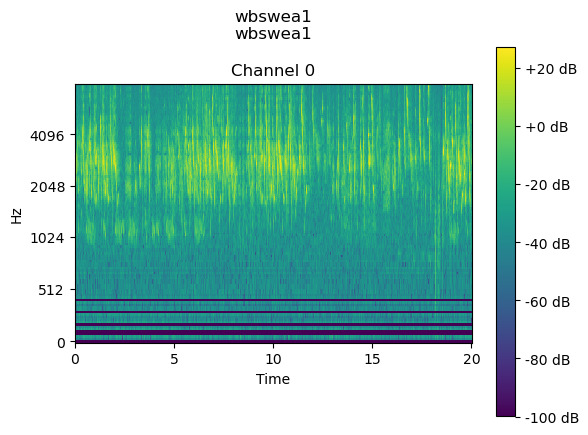

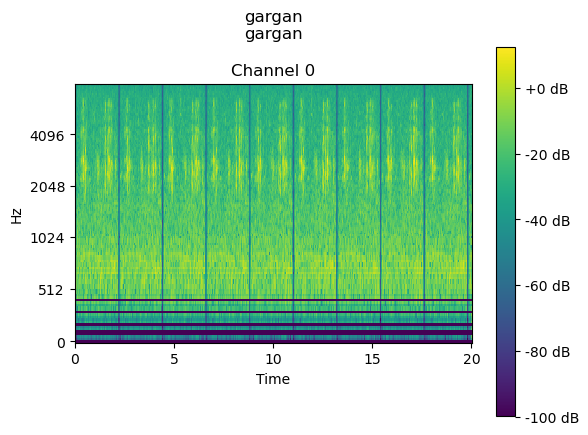

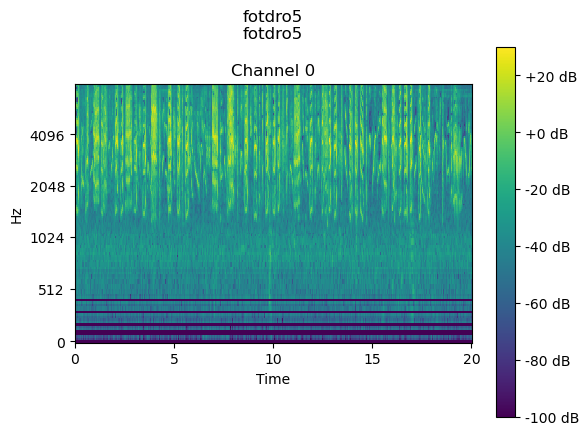

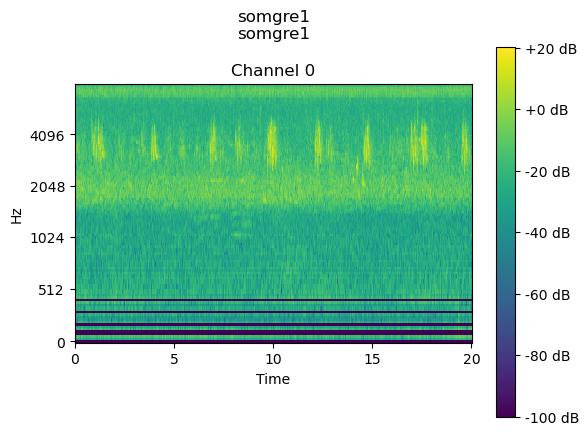

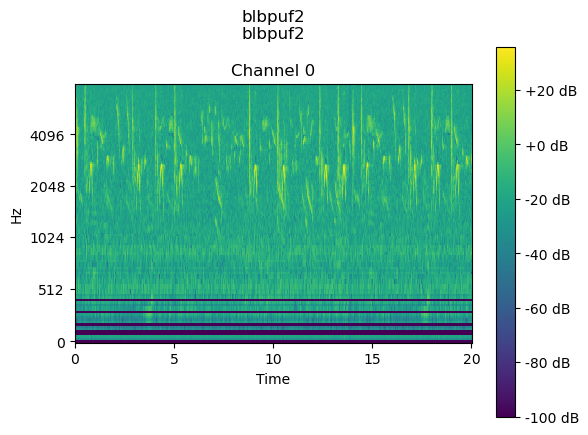

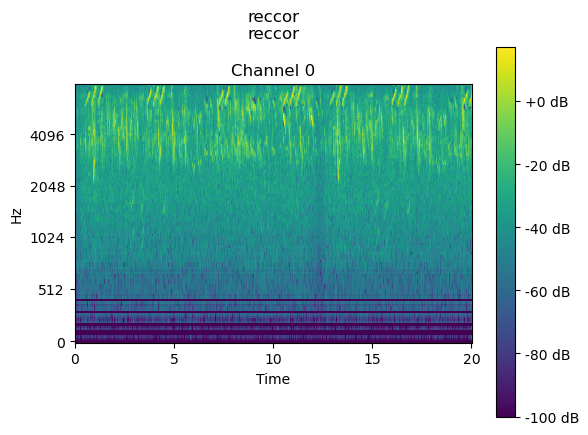

In [49]:
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="No positive class found in y_true, recall is set to one for all thresholds.")
learn.show_results()

# Interpretation

In [50]:
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="No positive class found in y_true, recall is set to one for all thresholds.")
interp = ClassificationInterpretation.from_learner(learn)

In [51]:
# interp.plot_top_losses(9)

In [52]:
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", message="No positive class found in y_true, recall is set to one for all thresholds.")
    # interp.plot_confusion_matrix()
confusion_matrix = interp.confusion_matrix()
confusion_matrix.shape

(264, 264)

In [53]:
len(dls.vocab)

264

In [54]:
confmat_df = pd.DataFrame(confusion_matrix, columns = dls.vocab, index=dls.vocab)

In [55]:
confmat_df

,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,afmdov1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
abethr1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abhori1,0,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abythr1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
afbfly1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
afdfly1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yertin1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0,0,0,0
yesbar1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
yespet1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yetgre1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [56]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="No positive class found in y_true, recall is set to one for all thresholds.")
    print(interp.most_confused()[:20])

[('cohmar1', 'barswa', 3), ('litegr', 'greegr', 3), ('abythr1', 'scrcha1', 2), ('blakit1', 'combul2', 2), ('bltori1', 'abhori1', 2), ('categr', 'greegr', 2), ('cohmar1', 'bagwea1', 2), ('combuz1', 'blakit1', 2), ('gnbcam2', 'grbcam1', 2), ('grbcam1', 'gnbcam2', 2), ('grecor', 'categr', 2), ('greegr', 'categr', 2), ('greegr', 'litegr', 2), ('lessts1', 'fotdro5', 2), ('litegr', 'categr', 2), ('rbsrob1', 'ratcis1', 2), ('rerswa1', 'barswa', 2), ('rerswa1', 'cohmar1', 2), ('rindov', 'greegr', 2), ('tafpri1', 'colsun2', 2)]


# Full Validation Assessment

In [57]:
comp_path.ls()

(#11) [Path('birdclef-2023/train_audio_prep-2'),Path('birdclef-2023/eBird_Taxonomy_v2021.csv'),Path('birdclef-2023/test_soundscapes'),Path('birdclef-2023/train_metadata.csv'),Path('birdclef-2023/train_audio_prep-2b'),Path('birdclef-2023/train_audio_prep-20-60s-32k'),Path('birdclef-2023/train_audio'),Path('birdclef-2023/sample_submission.csv'),Path('birdclef-2023/train_audio_prep'),Path('birdclef-2023/train_audio_prep-30s-32k')...]

In [58]:
tst_df = trn_df.loc[tst_idx]

In [59]:
tst_dl = learn.dls.test_dl(tst_df)

In [60]:
probs, _, idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

In [61]:
probs.shape

torch.Size([1559, 264])

In [62]:
idxs.shape

torch.Size([1559])

In [63]:
sub_sample_df = pd.read_csv(comp_path/'sample_submission.csv')
sub_sample_df.head()

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,soundscape_29201_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,soundscape_29201_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
preds = (probs > 0.5).int()

In [65]:
preds[0]

TensorBase([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [66]:
sub_df = pd.DataFrame(tst_df.reset_index().filename)
sub_df.columns = ['row_id']
# sub_df = pd.concat([sub_df, pd.DataFrame(preds, columns=learn.dls.vocab)], axis=1)  # breaks when debugging with a small number of images where classes are missing
sub_df = pd.concat([sub_df, pd.DataFrame(preds, columns=sub_sample_df.columns[1:])], axis=1)
sub_df.head()

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,cibwar1/XC447167.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,bawman1/XC413941.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,eswdov1/XC532294.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,afecuc1/XC233905.ogg,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,comsan/XC580492.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
truth_df = sub_df.copy()
truth_df.iloc[:, 1:] = 0
truth_df.describe()

,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,afmdov1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
count,1559.0,1559.0,1559.0,1559.0,1559.0,1559.0,1559.0,1559.0,1559.0,1559.0,...,1559.0,1559.0,1559.0,1559.0,1559.0,1559.0,1559.0,1559.0,1559.0,1559.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
for r, c in enumerate(tst_df.primary_label):
    truth_df.loc[r, c] = 1
truth_df.describe()

,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,afmdov1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
count,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,...,1559.0,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000,1559.000000
mean,0.000641,0.007697,0.001924,0.001283,0.001283,0.005773,0.002566,0.000641,0.004490,0.001924,...,0.0,0.000641,0.004490,0.001283,0.000641,0.008339,0.001924,0.000641,0.001924,0.006414
std,0.025327,0.087424,0.043839,0.035806,0.035806,0.075784,0.050604,0.025327,0.066879,0.043839,...,0.0,0.025327,0.066879,0.035806,0.025327,0.090964,0.043839,0.025327,0.043839,0.079858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [69]:
# Function provided here: https://www.kaggle.com/competitions/birdclef-2023/overview/evaluation

def padded_cmap_for_df(solution, submission, padding_factor=5):
    solution = solution.drop(['row_id'], axis=1, errors='ignore')
    submission = submission.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    # print(new_rows)
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    # print(padded_solution.shape)
    # print(padded_submission.shape)
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

In [70]:
# temporary for testing
truth_df

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,cibwar1/XC447167.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,bawman1/XC413941.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,eswdov1/XC532294.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,afecuc1/XC233905.ogg,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,comsan/XC580492.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,strher/XC255389.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1555,wlwwar/XC702799.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1556,yefcan/XC195768.ogg,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1557,eswdov1/XC756322.ogg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
pcmap = padded_cmap_for_df(truth_df, sub_df)
print(pcmap)

0.8050562721955236


In [72]:
sub_prob_df = pd.DataFrame(tst_df.reset_index().filename)
sub_prob_df.columns = ['row_id']
# sub_prob_df = pd.concat([sub_prob_df, pd.DataFrame(probs, columns=learn.dls.vocab)], axis=1)
sub_prob_df = pd.concat([sub_prob_df, pd.DataFrame(probs, columns=sub_sample_df.columns[1:])], axis=1)
pcmap_prob = padded_cmap_for_df(truth_df, sub_prob_df)
print(pcmap_prob)

0.9187045448608504


For comparison, what is the score when we predict all zeros or all ones?

In [73]:
sub_df.iloc[:, 1:] = 0
padded_cmap_for_df(truth_df, sub_df)

0.6191115788609122

In [74]:
sub_df.iloc[:, 1:] = 1
padded_cmap_for_df(truth_df, sub_df)

0.006972700147252577

# Export

In [75]:
# Model
timestr = time.strftime("%Y%m%d-%H%M%S")
model_fname = Path(f"birdclef-2023-{hypp['nn_arch']}-{timestr}.pkl")
if iskaggle:
    model_fname = Path('/kaggle/working')/model_fname
model_fname

Path('birdclef-2023-convnext_tiny_in22k-20230429-191518.pkl')

In [76]:
# Confusion matrix
confmat_df.to_csv(f'confmat-{timestr}.csv')

In [77]:
if wandb_on:
    wandb.log({
        'model_fname': str(model_fname),
        'padded_cmap': pcmap,
        'padded_cmap_probs': pcmap_prob,
        'trn_sub_folder': hypp['data_prep_details']['prep_dir']
    })
    wandb.finish()
    learn.remove_cbs(wandb_callback)

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▆▄▃▂▂▁▁▁
lr_0,▁▃▅▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▃▅▇█▂▂▂▃▃▃▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
mom_0,█▇▄▂▁██▇▆▅▄▃▂▁▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇████
mom_1,█▇▄▂▁██▇▆▅▄▃▂▁▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▅▆▆▇▇▇▇████
padded_cmAP,▁▂▄▅▆▇███
padded_cmAP_probs,▁▃▅▆▇▇███
padded_cmap,▁


In [78]:
learn.export(model_fname)

In [79]:
# Also save the test indices associated with this model for separate experimentation with threholding / binarization to optimize pF1
split_fname = Path(str(model_fname.with_suffix('')) + '-test_indices').with_suffix('.pkl')
if iskaggle:
    split_fname = Path('/kaggle/working')/split_fname
    
with open(split_fname, 'wb') as fhandle:
    pickle.dump(tst_idx, fhandle)

In [80]:
pcmap_prob

0.9187045448608504